In [143]:
# general
import pandas as pd
import numpy as np
from time import time
import pickle 

# modeling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

# pretty
from pprint import PrettyPrinter
pp = PrettyPrinter()

# mute warnings
import warnings
warnings.filterwarnings('ignore')

## Load

In [25]:
df_train = pd.read_csv('../data/train_standard.csv', parse_dates=['date'], dtype={'fullVisitorId': 'str'})

In [26]:
df_train.head()

,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.isMobile,geoNetwork.continent,totals.bounces,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.isTrueDirect,referred_channelGrouping,social_channelGrouping,device.OS_chrome,classifier_predict_probas
0,2016-09-02,1131660440785968503,1,1,1,0,0,1.0,1,1.0,0.0,0,0,0,0,0.0
1,2016-09-02,377306020877927890,1,0,0,0,0,1.0,1,1.0,0.0,0,0,0,0,0.0
2,2016-09-02,3895546263509774583,1,0,1,0,0,1.0,1,1.0,0.0,0,0,0,0,0.0
3,2016-09-02,4763447161404445595,1,0,0,0,0,1.0,1,1.0,0.0,0,0,0,0,0.0
4,2016-09-02,27294437909732085,2,1,1,1,0,1.0,1,1.0,0.0,1,0,0,0,0.0


In [209]:
# Separate Train and Target
target = df_train['totals.transactionRevenue'].apply(lambda x: 0 if x==0 else np.log(x))
train_cols = [col for col in df_train.columns[2:] if col != 'totals.transactionRevenue']
train = df_train[train_cols]

# Standardize
scaler = StandardScaler()
train = pd.DataFrame(data=scaler.fit_transform(train), columns=train_cols)

# Funcs

In [16]:
def grid_regressor(model, train, target, parameters={}, cv=4, timed=True, verbose=True, plot=False):
    '''
    For tuning models.
    
        Parameters:
        -----------
    model - sklearn model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv results
    plot - boolean, makes a seaborn plot of the cv results, one parameter only
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    
    # GridSearch fitting
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='neg_mean_squared_error',
        n_jobs=4,
        cv=cv)
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
        
    # Verbose Printout
    if verbose:
        print('Grid Scores: \n')
        pp.pprint(results)
        print(f'Best Model Parameters: {gsearcher.best_params_}')
        print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    # Plot CV Results
    if plot:
        y = results['mean_test_score']
        x = range(len(y))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(8,6))
        plt.scatter(x=x, y=y)
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('MSE')
        plt.xticks(x, labels, rotation=60)
    
    return gsearcher

In [13]:
def model_validate(model, train, target, cv=5, timed=True, verbose=True, feature_importance=False, feature_cols=None):
    '''
    For validating a model's score on a single set of parameters.
    
        Paramters:
        ----------
    model - sklearn model, parameters set on instantiation
    train - array of training data
    target - array of target data
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv_results
    feature_importance - boolean, makes a seaborn plot of the feature importance, only works for ensembles
    feature_cols - list of strings, column labels for the feature importance plot, ensemble only
    
        Returns:
        ---------
    model - the fitted sklearn model

    '''
    # Fit and Predict
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    model.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    
    # CV
    cv_score = cross_validate(model, train, target, cv=cv, scoring='neg_mean_squared_error')
    if verbose:
        print('Average MSE:', np.mean(cv_score['test_score']))
        print('Std Dev:', np.std(cv_score['test_score']))
    if timed:
        passed = time() - start
        print(f'Seconds to CV: {passed:.2f}')
    
    # Plots feature importance, for ensemble models only
    if feature_importance:
        feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)
    
    return model

# Modeling

The final model that is ran on the test set will have two parts: Classify if a visitor will make a purchase and then Predict that purchase value. If the data point has a lower probability of a purchase than that of some determined threshold, then it'll just be labeled as zero and never sent to the Predictor. The motivation for this modeling approach is that of the 903k training data points, only 11k made an actual perchase. First modeling runs without separating out the zeros proved fruitless.

The workflow:
* Determine Classifier Threshold
* Run Regression models with only known spenders
* Run Regression models with Classified spenders

## Determine Threshold

The predicted probabilities from the classifier will be used to generate a ROC curve. Priority will be on a higher True Negative Rate because there's not a lot of people who spent money and they are the much more useful data points for training the Regressor. Maximizing the TNR (minimizing the FPR) will results in fewer loss of spenders. Will pick 3-4 thresholds to use for the following sections. Yes, that means 3-4 different datasets for each gridsearched regressor but the threshold should definitely be CV'd somehow and not just picked on intuition. 

In [83]:
y_true = df_train['totals.transactionRevenue'].apply(lambda x: 0 if x==0 else 1)
y_pred = df_train['classifier_predict_probas']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

Text(0.5,1,'ROC of Classifying Spenders')

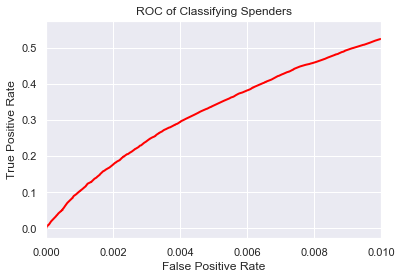

In [117]:
plt.figure()
plt.plot(fpr[:1000], tpr[:1000], color='red', lw=2)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.01])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Classifying Spenders')

In [118]:
thresholds[-1000]

0.1214

In [120]:
def inspector(threshold): 
    df_spend = df_train[df_train['classifier_predict_probas'] > threshold]
    df_no_spend = df_train[df_train['classifier_predict_probas'] <= threshold]
    
    tp = df_spend[df_spend['totals.transactionRevenue'] > 0]['totals.transactionRevenue']
    tn = df_no_spend[df_no_spend['totals.transactionRevenue']==0]['totals.transactionRevenue']
    fp = df_spend[df_spend['totals.transactionRevenue']==0]['totals.transactionRevenue']
    fn = df_no_spend[df_no_spend['totals.transactionRevenue'] > 0]['totals.transactionRevenue']
    
    print('Predict Spend')
    print(len(df_spend), round(len(df_spend)/len(df_train), 2))
    print('TPR:', round(len(tp)/len(df_spend), 3), len(tp))
    print('FPR:', round(len(fp)/len(df_spend), 3), len(fp))
    
    print('---')
    
    print('Predict No Spend')
    print(len(df_no_spend), round(len(df_no_spend)/len(df_train), 2))
    print('TNR:', round(len(tn)/len(df_no_spend), 3), len(tn))
    print('FNR:', round(len(fn)/len(df_no_spend), 3), len(fn))

In [121]:
for threshold in [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25]:
    print('-'*50, '\n', threshold, '\n')
    inspector(threshold)
    print()

-------------------------------------------------- 
 0.005 

Predict Spend
82971 0.09
TPR: 0.138 11426
FPR: 0.862 71545
---
Predict No Spend
820682 0.91
TNR: 1.0 820593
FNR: 0.0 89

-------------------------------------------------- 
 0.01 

Predict Spend
72612 0.08
TPR: 0.156 11363
FPR: 0.844 61249
---
Predict No Spend
831041 0.92
TNR: 1.0 830889
FNR: 0.0 152

-------------------------------------------------- 
 0.02 

Predict Spend
62234 0.07
TPR: 0.18 11222
FPR: 0.82 51012
---
Predict No Spend
841419 0.93
TNR: 1.0 841126
FNR: 0.0 293

-------------------------------------------------- 
 0.05 

Predict Spend
48279 0.05
TPR: 0.224 10798
FPR: 0.776 37481
---
Predict No Spend
855374 0.95
TNR: 0.999 854657
FNR: 0.001 717

-------------------------------------------------- 
 0.1 

Predict Spend
37292 0.04
TPR: 0.268 9983
FPR: 0.732 27309
---
Predict No Spend
866361 0.96
TNR: 0.998 864829
FNR: 0.002 1532

-------------------------------------------------- 
 0.15 

Predict Spend
29776 0.03


Going with thresholds of 0.01, 0.1, and 0.2. Each of these will generate a new training set for the regressors.

0.01 might be good because 1.3% of the spenders are mislabled as zeros. 

0.1 may be good because there's roughly a 2 to 1 ratio of zeros to spenders vs. a 6 to 1 for the 0.01 threshold. However the regressing dataset would be missing 13.3% of spenders.

0.2 probably won't be good, but let's run models on it anyway.

The 4th and last Classifier-Regressor combo will be a 0.01 dataset, a Regressor trained on only known spenders, and CV'd against the whole dataset. 

In [162]:
# indices
idxs_01 = df_train[df_train['classifier_predict_probas'] > 0.01].index
idxs_10 = df_train[df_train['classifier_predict_probas'] > 0.10].index
idxs_20 = df_train[df_train['classifier_predict_probas'] > 0.20].index
idxs_spend = df_train[df_train['totals.transactionRevenue'] > 0].index

---
# Modeling

Since the Regressor will be trained with a different dataset, (the 1%, 10%, and 20% datasets) all final models need to be CV'd against the entire dataset. This means that the MSE used to determine the best model will be calculated with the Classifiers predicted zeros and the Regressors predicted values against the actual transaction revenue. Sklearn's GridSearchCV and cross_validate are built to use only one model, so a function must be built to perform this niche CV. 
This function will:
* Train the Regressor on the desired subsample of data
* Append each model's predictions to the Classifiers zeros
* Compute the RMSE for each set of predictions
* Plot the RMSE

In [205]:
def partitioner(dataset, n_folds):
    '''
    
    '''
    dataset = dataset.copy()
    partitions = []
    for n in range(n_folds):
        frac = 1/(n_folds - n)
        if frac != 1:
            sample_idxs = dataset.sample(frac=frac, random_state=42).index
            partitions.append(dataset.loc[sample_idxs])
            dataset.drop(sample_idxs, inplace=True)
        else:
            partitions.append(dataset)
    return partitions

In [201]:
partitions[0].head()

816388    18.197412
737725          NaN
546467          NaN
300915    17.581583
633354          NaN
Name: totals.transactionRevenue, dtype: float64

In [ ]:
def gsearch_regressor(model, reg_idxs, parameters, cv=4, timed=True, plot=False):
    '''
    For tuning models.
    
        Parameters:
        -----------
    model - sklearn model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv results
    plot - boolean, makes a seaborn plot of the cv results, one parameter only
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed: start = time()
    
    train_reg = df_train.iloc[reg_idxs][train_cols]
    target_reg = df_train.iloc[reg_idxs]['totals.transactionRevenue']
    target_reg = target_reg.apply(lambda x: 0 if x==0 else np.log(x))
    
    # GridSearch fitting
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        cv=cv)
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
        
    # Verbose Printout
    if verbose:
        print('Grid Scores: \n')
        pp.pprint(results)
        print(f'Best Model Parameters: {gsearcher.best_params_}')
        print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    # Plot CV Results
    if plot:
        y = results['mean_test_score']
        x = range(len(y))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(8,6))
        plt.scatter(x=x, y=y)
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('MSE')
        plt.xticks(x, labels, rotation=60)
    
    return gsearcher

In [293]:
def modeler(model, reg_idxs, parameters={}, cv=5, feature_cols=None):
    '''
    For both tuning and validating models.
    
    Using the indices provided from reg_idxs this function assumes that all other indices in 
    the dataframe are predicted as non-spenders. Then the function will either gridsearch 
    over the parameters or just train the model - this depends on the "parameters" argument. 
    A printout of the MSEs for the total dataset and the Regressor partition dataset follows. 
    If a gridsearch happened, a plot of the scores follows. Finally, if a gridsearch did NOT
    happen AND the feature_cols is set to train_cols. Then their will be a feature importances
    bar plot; helpful for ensemble methods. Returns the trained/best model.
    
        Parameters:
        -----------
    model - sklearn model
    reg_idxs - the indices the of dataset the Regressor will be trained on
    parameters - dict of parameters the GSearcher will run over, leave empty if not tuning
    cv - int, k-fold number
    feature_cols - list of strings, column labels for the feature importance plot, ensemble only
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    
    '''
    start = time()
    
    train_reg = train.iloc[reg_idxs][train_cols]
    target_reg = target.iloc[reg_idxs]
    
    # Fit
    if parameters:
        gsearcher = GridSearchCV(
            estimator=model, 
            param_grid=parameters,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            cv=cv)
        gsearcher.fit(train, target)
        results = gsearcher.cv_results_
        model = gsearcher.best_estimator_
        best_params = gsearcher.best_params_
    else:
        model.fit(train_reg, target_reg)

    # Predict
    reg_preds = model.predict(train_reg)
    y_pred = pd.Series(np.zeros(len(df_train)))
    for idx, pred in zip(reg_idxs, reg_preds):
        y_pred.set_value(idx, pred)
    
    # MSE
    total_MSE = mean_squared_error(y_true, y_pred)
    reg_MSE = mean_squared_error(target_reg, reg_preds)
    print('- ' * 50)
    print('Total MSE:\t', round(total_MSE, 4))
    print('Reg MSE:\t', round(reg_MSE, 4))
    print('- ' * 50)
    
    # Gsearch Report
    if parameters:
        scores = list(results['mean_test_score'])
        best = max(scores)
        print('Mean Test Scores:', scores)
        print('Best Test Index:', scores.index(best))
        print('Best Test Score:', round(best, 4))
        print('Best Parameter:', best_params)
    
    # Plots feature importance, for ensemble models only
    if feature_cols:
        feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)
    
    # Plot CV Results
    if parameters:
        y = results['mean_test_score']
        x = range(len(y))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(8,6))
        plt.scatter(x=x, y=y)
        plt.title(f'{model_name} over {param}\n(Regressor Dataset Only)', fontsize=18)
        plt.xlabel(param)
        plt.ylabel('MSE')
        plt.xticks(x, labels, rotation=60)

    print(f'Seconds: {time() - start}')
    
    return model

---
## 1% Threshold Dataset

---
### BayesianRidge

In [280]:
model = BayesianRidge
reg_idxs = idxs_01

bayes_model = modeler(BayesianRidge(), reg_idxs)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.8454
Reg MSE:	 34.7735
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 0.5241892337799072


---
### OLS

In [281]:
model = LinearRegression()
reg_idxs = idxs_01

linear_model = modeler(model, reg_idxs)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.8454
Reg MSE:	 34.7734
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 0.5071489810943604


---
### Ridge

---
#### Baseline

In [282]:
model = Ridge(random_state=42)
reg_idxs = idxs_01

ridge_model = modeler(model, reg_idxs)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.8454
Reg MSE:	 34.7734
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 0.4817538261413574


---
#### alpha
Default: 1.0

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.8459
Reg MSE:	 34.7796
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Mean Test Scores: [-2.847147176199734, -2.8471471759728204, -2.8471471756892037, -2.847147173421269, -2.8471471705888476, -2.847147148029348, -2.847147120079629, -2.8471469064626396, -2.8471466643669587]
Best Test Index: 8
Best Test Score: -2.8471
Best Parameter: {'alpha': 100}
Seconds: 13.316991090774536


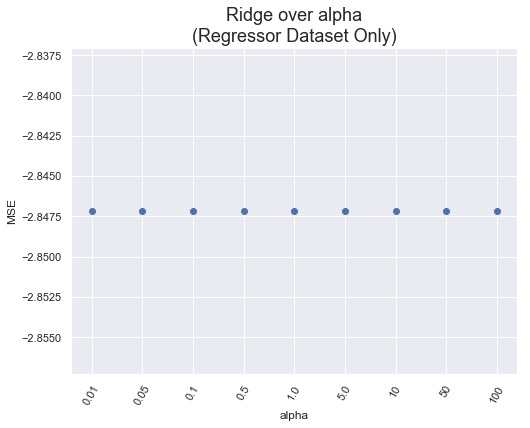

In [283]:
model = Ridge(random_state=42)
reg_idxs = idxs_01
parameters = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 50, 100]}

ridge_model = modeler(model, reg_idxs, parameters=parameters)

Not a significant amount of variation above so sticking with the default value.

---
### Lasso

---
#### Baseline

In [286]:
model = Lasso(random_state=42)
reg_idxs = idxs_01

lasso_model = modeler(model, reg_idxs)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.8587
Reg MSE:	 34.9399
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 0.46265673637390137


---
#### alpha
Default: 1.0

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.8461
Reg MSE:	 34.7821
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Mean Test Scores: [-2.846993806724086, -2.849338040343019, -2.856774338534613, -3.096504970784448, -3.8467688778894518, -4.01487091038447, -4.01487091038447, -4.01487091038447, -4.01487091038447]
Best Test Index: 0
Best Test Score: -2.847
Best Parameter: {'alpha': 0.01}
Seconds: 14.966046810150146


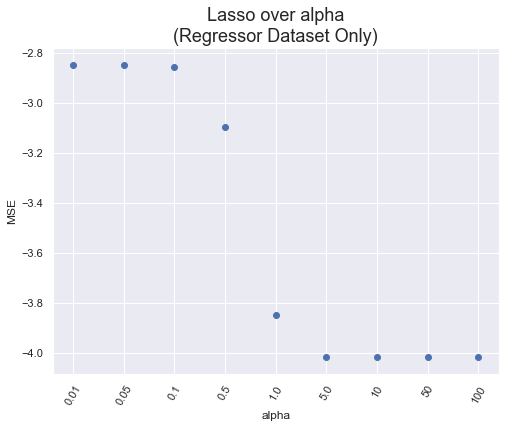

In [288]:
model = Lasso(random_state=42)
reg_idxs = idxs_01
parameters = {'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 50, 100]}

lasso_model = modeler(model, reg_idxs, parameters=parameters)

Lasso gets a little better with tuning Alpha but the tuned model is ultimately on par with Ridge, OLS, and Bayes. Makes sense since an alpha = 0 makes it OLS anyway.

---
### Random Forest

---
#### Baseline

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.4228
Reg MSE:	 29.5143
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 1.514294147491455


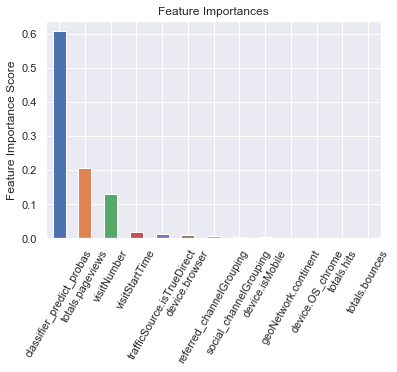

In [294]:
model = RandomForestRegressor(random_state=42)
reg_idxs = idxs_01

rf_model = modeler(model, reg_idxs, feature_cols=train_cols)

---
#### n_estimators
Default: 10

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.3888
Reg MSE:	 29.0917
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Mean Test Scores: [-3.2072474509057023, -3.1774779677214315, -3.1688682031701125, -3.1637670127073334, -3.1611911088522398, -3.1588283956207417, -3.15762372136402, -3.156686756197251, -3.155924547384309, -3.1554642273660436, -3.1546610940617956, -3.1537494156906973, -3.1533205852885833, -3.1527567351557786, -3.1525766023139767, -3.152035206764701, -3.151971778877252, -3.1521945860379086, -3.152000050491651, -3.1520904302468034]
Best Test Index: 16
Best Test Score: -3.152
Best Parameter: {'n_estimators': 170}
Seconds: 7022.248361825943


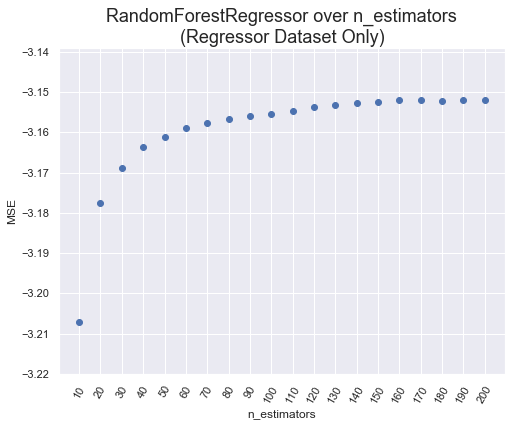

In [298]:
model = RandomForestRegressor(random_state=42)
reg_idxs = idxs_01
parameters = {'n_estimators': np.linspace(10, 200, 20).astype(int)}

rf_model = modeler(model, reg_idxs, parameters=parameters)

Final model will have 170 estimators but for tuning max_features the model will use 100 due to lengthy training times.

---
#### max_features
Default: "auto" (n_features)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.3897
Reg MSE:	 29.1024
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Mean Test Scores: [-3.1622948577354704, -3.159808679098504, -3.1572601560278803, -3.15633497664266, -3.1558861637992695, -3.153899975506263, -3.1527914280172435, -3.155424122508151]
Best Test Index: 6
Best Test Score: -3.1528
Best Parameter: {'max_features': 9}
Seconds: 1508.8655459880829


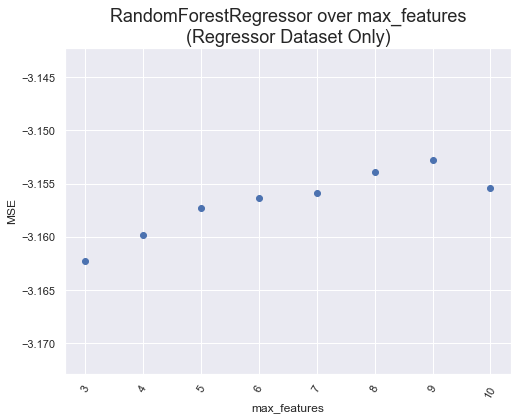

In [319]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_idxs = idxs_01
parameters = {'max_features': range(3, 11)}

rf_model = modeler(model, reg_idxs, parameters=parameters)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.389
Reg MSE:	 29.0935
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 18.31916093826294


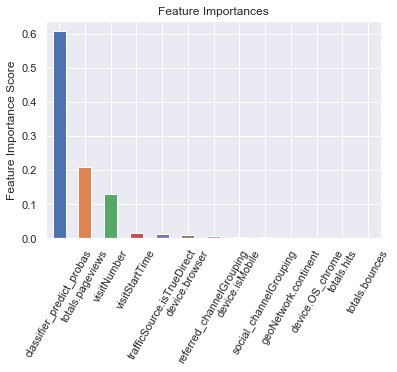

In [321]:
model = RandomForestRegressor(n_estimators=170, random_state=42)
reg_idxs = idxs_01

rf_model = modeler(model, reg_idxs, feature_cols=train_cols)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total MSE:	 2.3888
Reg MSE:	 29.0911
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Seconds: 12.91598105430603


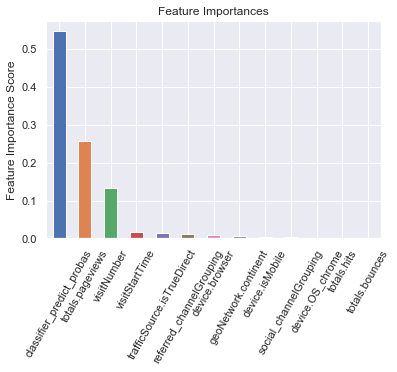

In [320]:
model = RandomForestRegressor(n_estimators=170, max_features=9, random_state=42)
reg_idxs = idxs_01

rf_model = modeler(model, reg_idxs, feature_cols=train_cols)